# <center> __Credit Risk Project:__

__Group Assignment:__
- *Ahmed Abdelazeem* (m20210433)
- *João Silva Ferreira* (m20210201)
- *Pedro Moura Gomes* (m20200322)
- *Omar Jarir* (m20201378)

***

__Importing the necessary libraries:__

In [1]:
import time
t1 = time.perf_counter()

In [2]:
import scipy.optimize as opt
from math import exp, log, sqrt
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import dataframe_image as dfi #pip install dataframe_image
import statsmodels.api as sm
import seaborn as sns
sns.set()

In [3]:
import warnings
warnings.filterwarnings("ignore")

__Helper functions:__

In [4]:
# In this section, some functions are defined to help with further computations

In [5]:
def EquityValue(V, F, tau, sigmaV, r):
    """
    V: Total value of the firm
    F: Face value of debt
    tau: Time-to-maturity
    sigmaV: Volatility of V 
    r: risk-free rate
    """
    #Other variations of the formula, switching r with mu can be used further

    d1 = (log(V/F)+(r+sigmaV**2/2.0)*tau)/(sigmaV*sqrt(tau))
    d2 = d1-sigmaV*sqrt(tau)
    E = V*norm.cdf(d1) - F*exp(-r*tau)*norm.cdf(d2) 
    return E

In [6]:
def EquityVol(V, F, tau, sigmaV, r, E):
    """
    V: Total value of the firm
    F: Face value of debt
    tau: Time-to-maturity
    sigmaV: Volatility of V 
    r: risk-free rate
    E: Market-value of Equity
    """
    
    d1 = (log(V/F)+(r+sigmaV**2/2.0)*tau)/(sigmaV*sqrt(tau))    
    sigma_E = norm.cdf(d1)*(V/E)*sigmaV 
    return sigma_E

In [7]:
# Defining a function to solve the non-linear systems of equations
def f(variables, *inputs):
    """
    variables: V, sigmaV 
    *inputs: a list of inputs 
    """
    
    (x,y) = variables
    # x is the spot
    # y is the sigma V.
    F,tau,r,equity,sigmaE = inputs 
    eq1 = equity - EquityValue(x,F,tau,y,r)
    eq2 = sigmaE - EquityVol(x,F,tau,y,r,equity)
    return [eq1, eq2]

In [8]:
def DistanceToDefault(V, F, tau, sigmaV, r):
    """
    V: Total value of the firm
    F: Face value of debt
    tau: Time-to-maturity
    sigmaV: Volatility of V 
    r: risk-free rate
    """
    
    d1 = (log(V/F)+(r-sigmaV**2/2.0)*tau)/(sigmaV*sqrt(tau))
    return d1

In [9]:
def d1_d2(V, F, tau, sigmaV, r):
    """
    V: Total value of the firm
    F: Face value of debt
    tau: Time-to-maturity
    sigmaV: Volatility of V 
    r: risk-free rate
    """
    
    d1 = (log(V/F)+(r+sigmaV**2/2.0)*tau)/(sigmaV*sqrt(tau))
    d2 = d1-sigmaV*sqrt(tau)
    return norm.cdf(d1), norm.cdf(d2)

In [10]:
# This is a function to read data from the excel files, imported from Bloomberg Terminal.
def ReadingData(file, cols):
    """
    file: file name
    cols: columns name
    """
    
    ds_tmp = pd.read_excel(file)
    ds_tmp.columns = ds_tmp.iloc[5]
    ds_tmp_ = ds_tmp[7:][cols]
    ds_tmp_.reset_index(drop=True, inplace=True)
    # Converting the date to datetime.
    ds_tmp_['Date'] = pd.to_datetime(ds_tmp_['Date'])
    # Sorting the dataframe by date.
    ds_tmp_ = ds_tmp_.sort_values(by="Date")
    # To numeric:
    ds_tmp_[cols[1]] = pd.to_numeric(ds_tmp_[cols[1]])
    return ds_tmp_

In [11]:
# This is a function to group by month, returning the last value of each month
def ds_eom(ds):
    """
    ds: The pandas dataframe to be grouped by the last date on a month
    """  
    
    ds_tmp = pd.DataFrame()
    groups = ds.groupby([ds.set_index("Date").index.month])
    for idx, group in groups:
        ds_tmp = ds_tmp.append(group.iloc[-1])
    return ds_tmp

In [12]:
# This function splits a dataframe to a list of dataframes, one for each month
def ds_list(ds):
    """
    ds: The pandas dataframe to be split by months
    """
    
    g = ds.groupby(pd.Grouper(key="Date", freq="M"))
    return [group for _, group in g]

In [13]:
# This function returns the value of V and sigmaV, per month, using the iterative approach
def IterativeApproach(ds, trading_days, tau, V_i, V_i1, mu=0.01, rate=True, tol=10**-15):
    """
    ds: The pandas dataframe to be split by months
    trading_days: 252
    tau: time-to-maturity
    V_i: Total value of the firm at iteration=i 
    V_i1: Total value of the firm at the i+1
    mu: expected return on assets
    rate: boolean flag, if rate=true the risk-free rate is used  
    tol: tolerance level
    """
    
    dss = ds_list(ds)
    sigma_V = []
    
    for df in dss:
        condition = True
        while condition:
    
            sigma_V_i = np.sqrt(trading_days)*np.std(np.log1p(df[V_i].pct_change()).fillna(0))
            
            if rate==True:
                df[V_i1] = df.apply(lambda x: (x["Equity"]+x["Debt"]*exp(-tau*x["Rate"])*d1_d2(x[V_i], x["Debt"], tau, sigma_V_i, x["Rate"])[1])
                                      /d1_d2(x[V_i], x["Debt"], tau, sigma_V_i, x["Rate"])[0], axis=1)
            else:
        
                df[V_i1] = df.apply(lambda x: (x["Equity"]+x["Debt"]*exp(-tau*mu)*d1_d2(x[V_i], x["Debt"], tau, sigma_V_i, mu)[1])
                                      /d1_d2(x[V_i], x["Debt"], tau, sigma_V_i, mu)[0], axis=1)
        
            sigma_V_i1 = np.sqrt(trading_days)*np.std(np.log1p(df[V_i1].pct_change()).fillna(0))
        
            df[V_i] = df[V_i1]   
        
            condition = (sigma_V_i1 - sigma_V_i)**2 > tol 
    
        sigma_V.append(np.sqrt(trading_days)*np.std(np.log1p(df[V_i1].pct_change()).fillna(0)))
    return dss, sigma_V
    

In [14]:
# This function returns the value of V and sigmaV, per month, using the iterative approach while using the Drift approach by getting the mean log returns of the vector of monthly estimation of V
def IterativeApproachWithDrift(ds, trading_days, tau, V_i, V_i1, rate=True, tol=10**-15):
    """
    ds: The pandas dataframe to be split by months
    trading_days: 252
    tau: time-to-maturity
    V_i: Total value of the firm at iteration=i 
    V_i1: Total value of the firm at the i+1
    mu: expected return on assets
    rate: boolean flag, if rate=true the risk-free rate is used  
    tol: tolerance level
    """
    
    dss = ds_list(ds)
    sigma_V = []
    mu_V = []
    
    for df in dss:
        condition = True
        while condition:
    
            sigma_V_i = np.sqrt(trading_days)*np.std(np.log1p(df[V_i].pct_change()).fillna(0))
            mu = np.mean(np.log1p(df[V_i].pct_change()).fillna(0))
        
            if rate==True:
                df[V_i1] = df.apply(lambda x: (x["Equity"]+x["Debt"]*exp(-tau*x["Rate"])*d1_d2(x[V_i], x["Debt"], tau, sigma_V_i, x["Rate"])[1])
                                      /d1_d2(x[V_i], x["Debt"], tau, sigma_V_i, x["Rate"])[0], axis=1)
            else:
        
                df[V_i1] = df.apply(lambda x: (x["Equity"]+x["Debt"]*exp(-tau*mu)*d1_d2(x[V_i], x["Debt"], tau, sigma_V_i, mu)[1])
                                      /d1_d2(x[V_i], x["Debt"], tau, sigma_V_i, mu)[0], axis=1)
        
            sigma_V_i1 = np.sqrt(trading_days)*np.std(np.log1p(df[V_i1].pct_change()).fillna(0))
            
        
            df[V_i] = df[V_i1]   
        
            condition = (sigma_V_i1 - sigma_V_i)**2 > tol 
    
        sigma_V.append(np.sqrt(trading_days)*np.std(np.log1p(df[V_i].pct_change()).fillna(0)))
        mu_V.append(np.mean(np.log1p(df[V_i].pct_change()).fillna(0)))
        
    return dss, sigma_V, mu_V
    

In [15]:
# This function plots the time evolution of variables using matplotlib library 
def Plotting(ds, cols):
    """
    ds: The pandas dataframe to be split by months
    cols: The columns to plot.
    """
    fig, ax = plt.subplots(1, 1, figsize=(20, 10), constrained_layout=True)
    plt.rcParams['date.converter'] = 'concise'
    ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=20, maxticks=40))

    ax.plot(ds['Date'], ds[cols]) 
    ax.legend(cols,loc="upper left")
    fig.tight_layout()
    fig.show();

In [16]:
tau=1
trading_days=252

__Loading the data:__

__rate:__

In [17]:
# Loading the risk-free rates, 
# NOTE: the 10-year treasury yield was assumed to be the risk-free rate  
ds_rate = pd.read_csv("^TNX.csv", usecols=["Date", "Adj Close"])

# Converting the date to datetime.

ds_rate['Date'] = pd.to_datetime(ds_rate['Date'])

# Sorting the dataframe by date.

ds_rate = ds_rate.sort_values(by="Date")

ds_rate.rename(columns = {"Adj Close":'Rate'}, inplace=True)
ds_rate["Rate"] = ds_rate["Rate"]/100 

ds_rate.tail()

,Date,Rate
380,2022-04-03,NaN
381,2022-04-04,0.02412
382,2022-04-05,0.02556
383,2022-04-06,0.02609
384,2022-04-07,0.02652


__Debts__

__Short Term Debt:__

In [18]:
# NOTE: the short term debt was collected through the Bloomberg Terminal, it assumes the short term debt quarterly values, this will be padded to get daily estimations of short term debt
ds_shortterm_debt = ReadingData("IBM_stdebt.xlsx", ["Date", "BS_ST_BORROW"])
ds_shortterm_debt

5,Date,BS_ST_BORROW
4,2020-12-31,8151
3,2021-03-31,6535
2,2021-06-30,7776
1,2021-09-30,8860
0,2021-12-31,7761


__Long Term Debt:__

- We can see that the values of long term debt are a lot bigger compared to the values of the short term debt.

In [19]:
# NOTE: the long term debt was collected through the Bloomberg Terminal, it assumes the long term debt quarterly values, this will be padded to get daily estimations of long term debt
ds_longterm_debt = ReadingData("IBM_ltdebt.xlsx", ["Date", "BS_LT_BORROW"])
ds_longterm_debt

5,Date,BS_LT_BORROW
4,2020-12-31,56937
3,2021-03-31,54585
2,2021-06-30,52013
1,2021-09-30,50118
0,2021-12-31,47379


__The total debt correspond to:__

We use the following formula:

\begin{align}
D^{*}:=STD+\frac{LTD}{2}
\end{align}

In [20]:
ds_debt = ds_longterm_debt
ds_debt["Debt"] = ds_shortterm_debt["BS_ST_BORROW"] + 0.5*ds_longterm_debt["BS_LT_BORROW"] 
ds_debt.drop(columns= "BS_LT_BORROW", inplace=True)
ds_debt.reset_index(drop=True, inplace=True)

In [21]:
ds_Debt = ds_debt.set_index('Date').resample('D').pad()
ds_Debt.reset_index(inplace=True)
ds_Debt.tail()

5,Date,Debt
361,2021-12-27,33919.0
362,2021-12-28,33919.0
363,2021-12-29,33919.0
364,2021-12-30,33919.0
365,2021-12-31,31450.5


__Market Value of Equity:__

In [22]:
# NOTE: Here the Market Value of Equity is loaded into a dataframe, this is through downloading daily market capitalization values from Bloomberg Terminal
ds_Equity = ReadingData("IBM_mktcap.xlsx", ["Date", "CUR_MKT_CAP"])

ds_Equity.rename(columns = {"CUR_MKT_CAP":'Equity'}, inplace=True)
ds_Equity.reset_index(drop=True, inplace=True)

ds_Equity.tail()

5,Date,Equity
315,2022-04-01,117045.1947
316,2022-04-04,117153.1119
317,2022-04-05,115912.0641
318,2022-04-06,116361.7191
319,2022-04-07,115606.2987


__Daily Implied volatility__

In [23]:
# NOTE: Here the Implied Volatility is loaded into a dataframe, this is through downloading daily Implied Volatility values from Bloomberg Terminal
# NOTE: To obtain the values, the field IVOL_MONEYNESS was used, which yields an End of Day Volatility out of a composite of options which are near the money
ds_daily_impvol = ReadingData("IBM_moneyness.xlsx", ["Date", "IVOL_MONEYNESS"])

ds_daily_impvol["IVOL_MONEYNESS"]=ds_daily_impvol["IVOL_MONEYNESS"]/100.0

ds_daily_impvol.rename(columns = {"IVOL_MONEYNESS":'implied_vol'}, inplace=True)
ds_daily_impvol.reset_index(drop=True, inplace=True)

ds_daily_impvol.tail()

5,Date,implied_vol
315,2022-04-01,0.179681
316,2022-04-04,0.177850
317,2022-04-05,0.201717
318,2022-04-06,0.210724
319,2022-04-07,0.214370


__Joining the dataframes__

In [24]:
ds = pd.merge(
     pd.merge(   
     pd.merge(ds_Equity, ds_Debt, how="inner", on=["Date"]),
              ds_rate, how="inner", on=["Date"]),
              ds_daily_impvol, how="inner", on=["Date"])

- The dataframe contains the following variables "Date", "equity", "debt", "rate", "implied_vol", and "book_value".

In [25]:
ds

,Date,Equity,Debt,Rate,implied_vol
0,2021-01-04,110437.6190,36619.5,0.00917,0.274845
1,2021-01-05,112397.9446,36619.5,0.00955,0.268459
2,2021-01-06,115204.7745,36619.5,0.01042,0.252178
3,2021-01-07,114937.4574,36619.5,0.01071,0.223382
4,2021-01-08,114527.5711,36619.5,0.01105,0.217142
...,...,...,...,...,...
247,2021-12-27,118036.8621,33919.0,0.01481,0.185847
248,2021-12-28,118942.6304,33919.0,0.01481,0.181878
249,2021-12-29,119588.3267,33919.0,0.01543,0.181130
250,2021-12-30,120090.5349,33919.0,0.01515,0.181097


In [26]:
ds.isna().sum()

Date           0
Equity         0
Debt           0
Rate           0
implied_vol    1
dtype: int64

In [27]:
ds.dropna(inplace=True)

In [28]:
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
Equity,251.0,119907.027726,8642.998122,103858.448500,112295.164050,121868.362000,127566.263500,135172.13340
Debt,251.0,34496.932271,1202.563911,31450.500000,33782.500000,33827.500000,33919.000000,36619.50000
Rate,251.0,0.014401,0.001822,0.009170,0.013030,0.014810,0.015830,0.01746
implied_vol,251.0,0.201911,0.045878,0.143321,0.171632,0.189577,0.219926,0.44889


___

__1. Default risk models using Merton (1974), Vassalou and Xing (2004) and Bharath and Shumway (2008).__

# __Question a:__
    - Following the guidelines of Vassalou and Xing (2004) and Bharath and Shumway (2008), collect data from an individual firm at your choice for at least 1 year (more years is better). You can use Bloomberg, Datastream, etc. Draw some graphs showing the evolution of your variables, e.g. market value of equity, book value of equity, book-to-market ratio, debt value, risk-free rate, etc. Provide also a table reporting summary statistics for all the variables used in your sample see, for example, Bharath and Shumway (2008, Table 1).

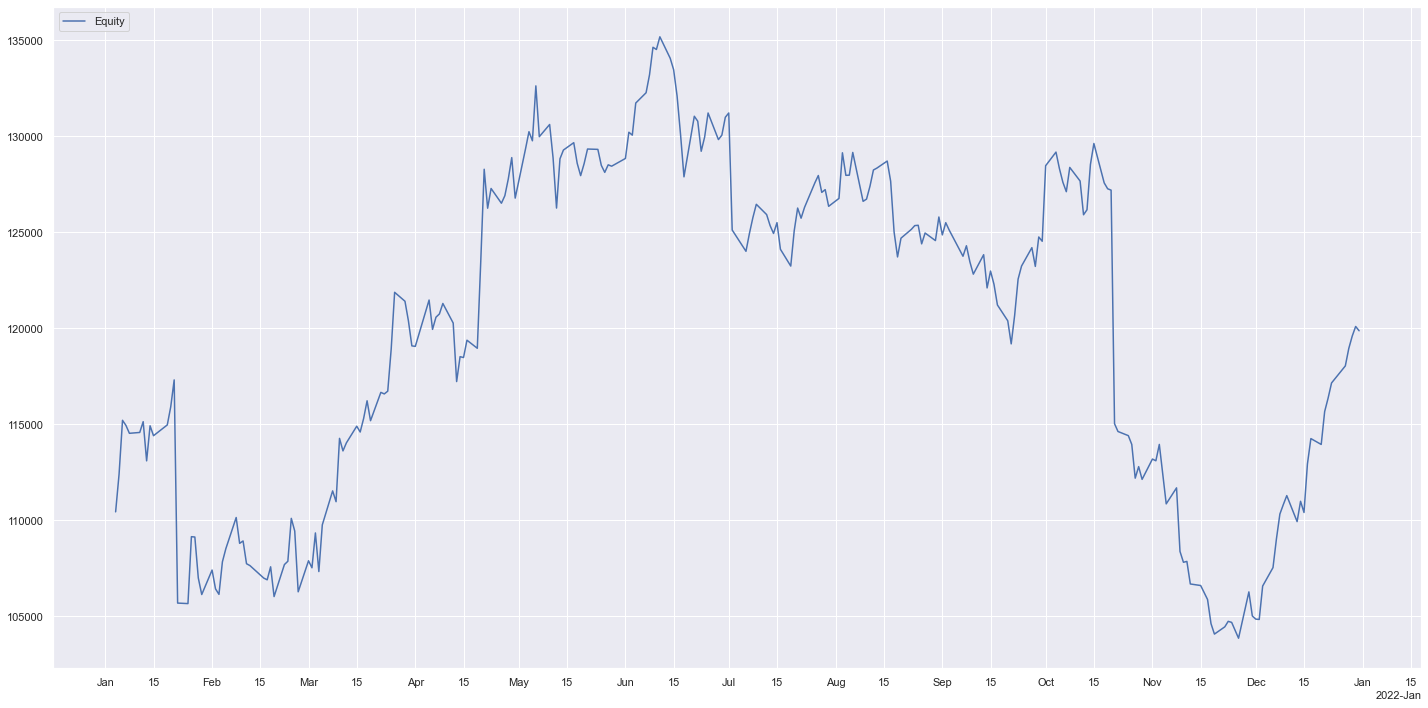

In [29]:
# Plotting the Equity of the company:

Plotting(ds, ["Equity"])

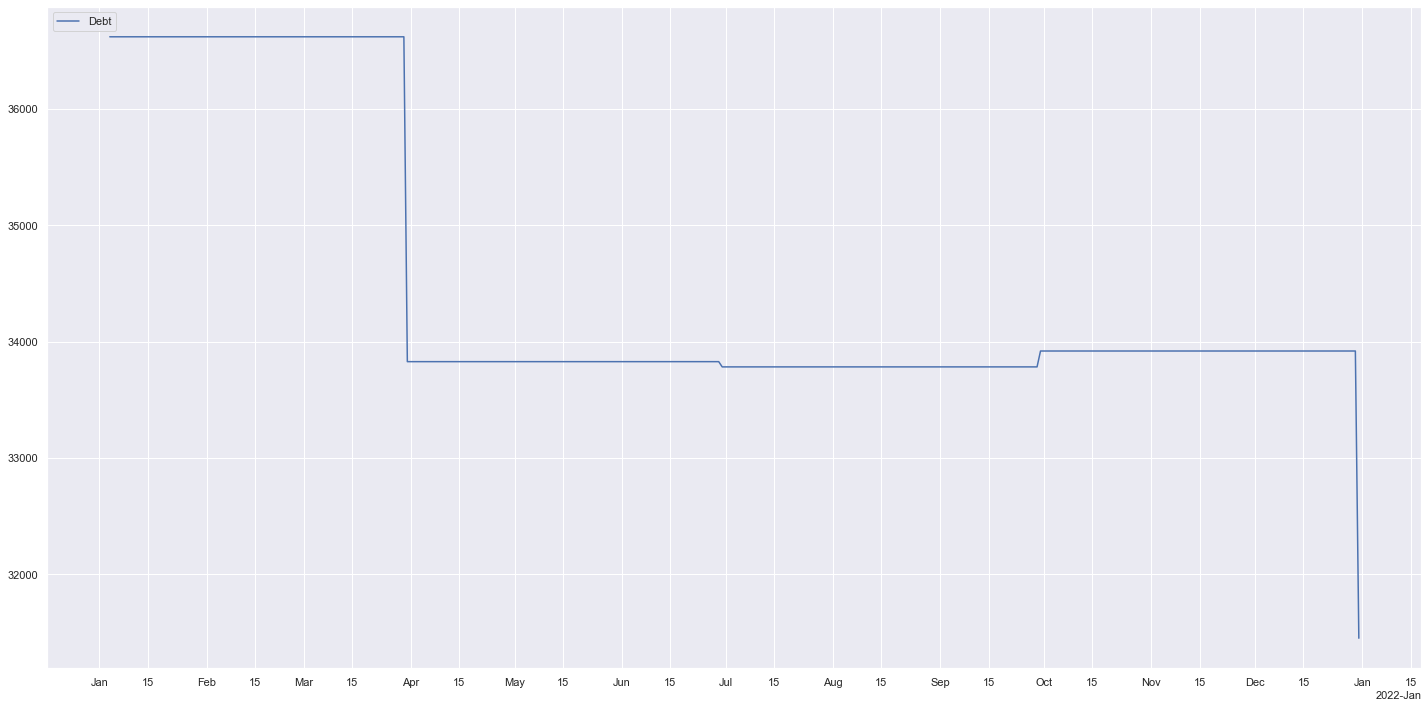

In [30]:
# Plotting the Debt of the company:

Plotting(ds, ["Debt"])

- We can see that the value of debt is decreasing.

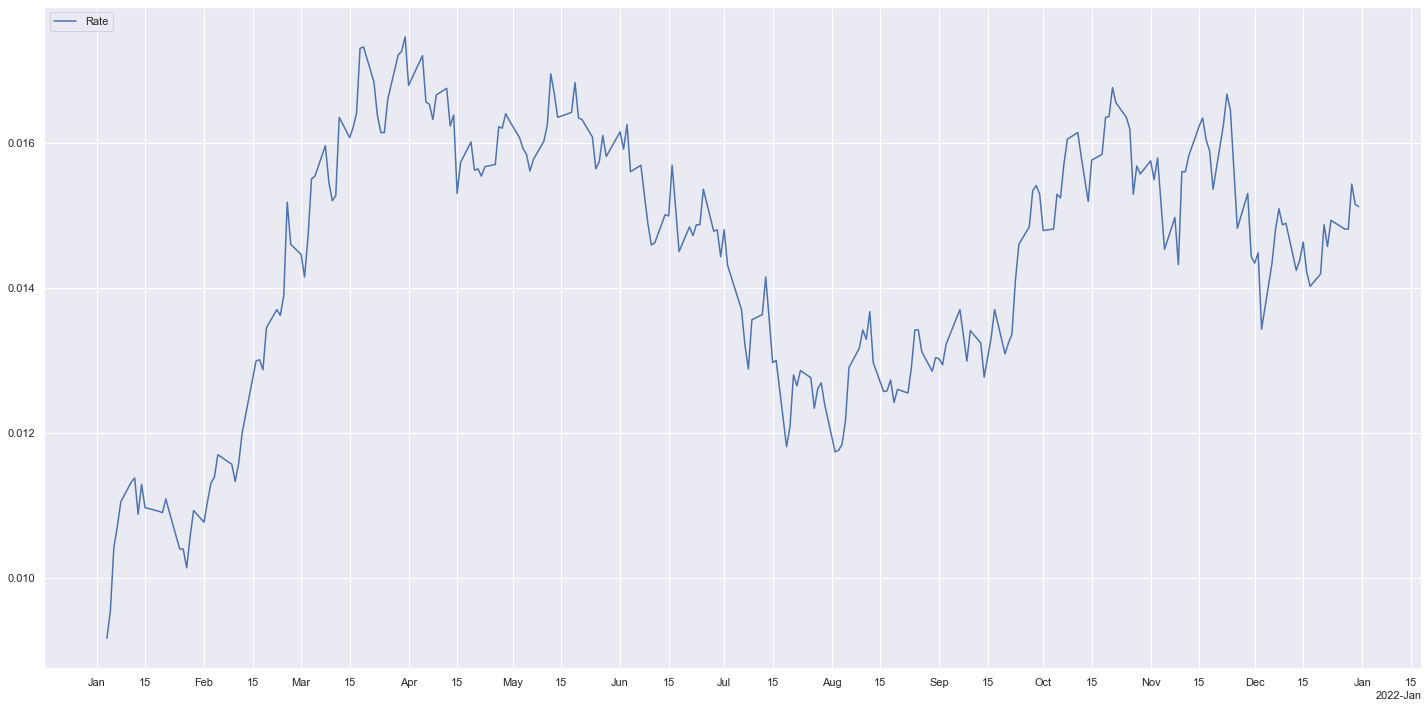

In [31]:
# Plotting the yield rate:

Plotting(ds, ["Rate"])

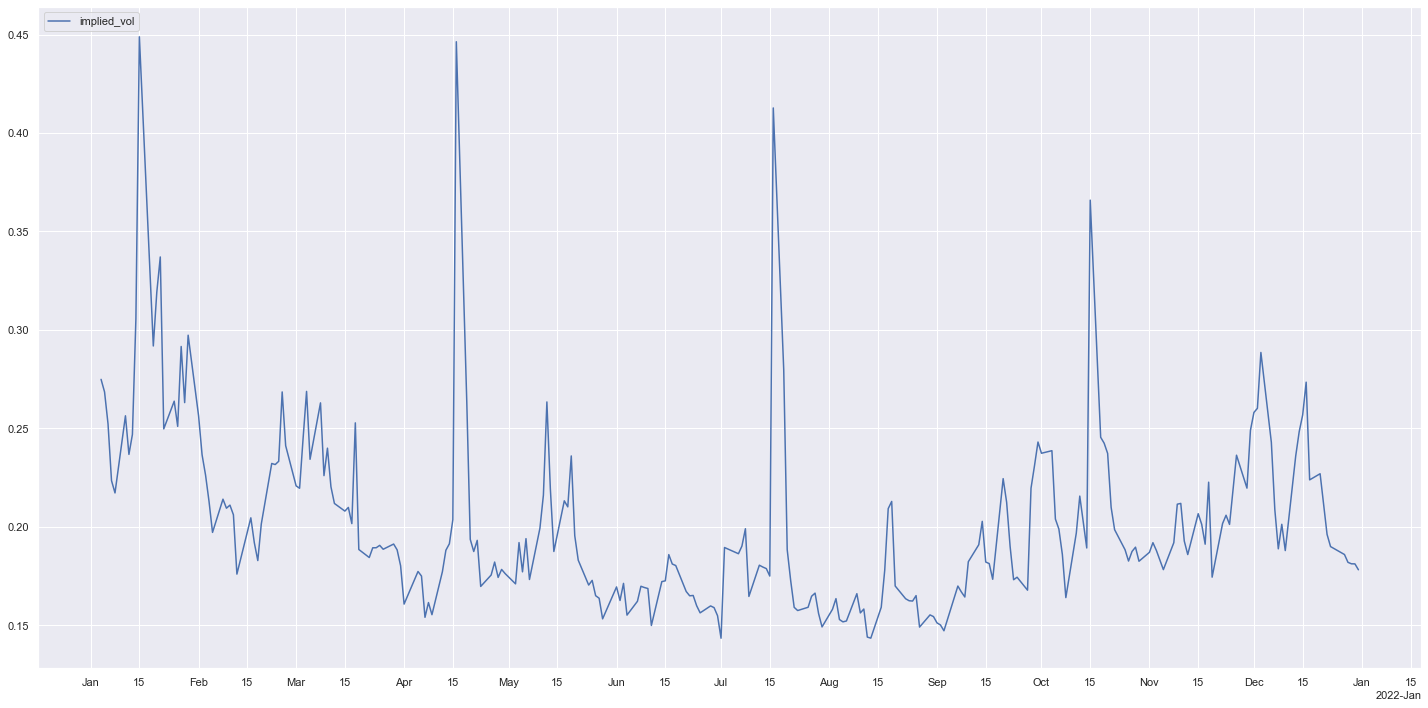

In [32]:
# Plotting the Implied volatility of the company:

Plotting(ds, ["implied_vol"])

In [33]:
ds.describe().T

,count,mean,std,min,25%,50%,75%,max
Equity,251.0,119907.027726,8642.998122,103858.448500,112295.164050,121868.362000,127566.263500,135172.13340
Debt,251.0,34496.932271,1202.563911,31450.500000,33782.500000,33827.500000,33919.000000,36619.50000
Rate,251.0,0.014401,0.001822,0.009170,0.013030,0.014810,0.015830,0.01746
implied_vol,251.0,0.201911,0.045878,0.143321,0.171632,0.189577,0.219926,0.44889


***

# __Question b:__
    - Compute the distance to default and the probability of default at the end of each month using Bharath and Shumway (2008,  Equations 6 and 7) exept that the expeted return on assets μ is replaced by the risk-free rate r and with the market value of assets and asset volatility being computed via the non-linear system of equations approach. To estimate equity volatility use 1 year of historical returns data. 

In [34]:
ds_previous_equity=ReadingData("grid1_rhcoltfv.xlsx", ["Date", "CUR_MKT_CAP"])

ds_previous_equity.rename(columns = {"CUR_MKT_CAP":'Equity'}, inplace=True)
ds_previous_equity.reset_index(drop=True, inplace=True)
ds_previous_equity=ds_previous_equity[:ds_previous_equity[ds_previous_equity["Date"]=="2021-12-31"].index[0]+1]

ds_previous_equity.tail()

5,Date,Equity
501,2021-12-27,118036.8621
502,2021-12-28,118942.6304
503,2021-12-29,119588.3267
504,2021-12-30,120090.5349
505,2021-12-31,119866.3348


In [35]:
# Getting the end of month dates.

eom_equity = [df["Date"].astype(str).tail(1).values for df in
              ds_list(ds_previous_equity[:ds_previous_equity[ds_previous_equity["Date"]=="2020-12-31"].index[0]+1])] +[df["Date"].astype(str).tail(1).values for df in ds_list(ds)]

eom_equity = [tmp[0] for tmp in eom_equity]

In [36]:
# Computing the values of sigma_E

sigma_E = []

for i, d in enumerate(eom_equity[:13]):
    df_tmp = ds_previous_equity[ds_previous_equity[ds_previous_equity["Date"]==eom_equity[i]].index[0]+1
             :ds_previous_equity[ds_previous_equity["Date"]==eom_equity[i+12]].index[0]+1]
    
    sigma_E.append(np.sqrt(trading_days)*np.std(np.log1p(df_tmp['Equity'].pct_change()).fillna(0)))
    
    
sigma_E = sigma_E[:-1]

- We have the following formulas:
    
\begin{align}
E_{t}\left(V,F,T\right)=V_{t}\mathcal{N}\left(d_{1}\right)-e^{-r\left(T-t\right)}F_{t}\mathcal{N}\left(d_{2}\right)
\end{align}

With:

\begin{align}
d_{1}=\frac{ln\left(\frac{V}{F}\right)+\left(r+\frac{\sigma_{V}}{2}\right)\left(T-t\right)}{\sigma_{V}\sqrt{T-t}}
\end{align}

and:

\begin{align}
d_{2}=d_{1}-\sigma_{V}\sqrt{T-t}
\end{align}

In [37]:
# Getting the values of V and sigma_V.

dss = ds_list(ds)

for i, df in enumerate(dss):
    df["V/sigma_V"] = df.apply(lambda x: opt.fsolve(f, (x["Equity"] + np.exp(-tau*x["Rate"])*x["Debt"], sigma_E[i]*x["Equity"]/(x["Equity"] + np.exp(-tau*x["Rate"])*x["Debt"])),
                              args=(x["Debt"], tau, x["Rate"], x["Equity"], sigma_E[i])) , axis=1)
    
    # Creating columns with the value of V and sigma_V.
    df[["Qb_V", "Qb_sigma_V"]] = pd.DataFrame(df["V/sigma_V"].tolist(), index= df.index)
    df.drop(columns=["V/sigma_V"], inplace=True)

ds = pd.concat(dss, axis=0)

In [38]:
ds_eom_Qb = ds_eom(ds)

- Calculating the distance to default, given by:
\begin{align}
DD=\frac{ln\left(\frac{V_{t}}{X}\right)+\left(\mu-\frac{\sigma_{V}^{2}}{2}\right)\left(T-t\right)}{\sigma_{V}\sqrt{T-t}}
\end{align}

In [39]:
# Calculating the distance to default:

ds_eom_Qb["Qb_DD"] = ds_eom_Qb.apply(lambda x: DistanceToDefault(x["Qb_V"], x["Debt"], tau, x["Qb_sigma_V"],
                                                             x["Rate"]), axis=1)

- Calculating the probability to default, given by:

\begin{align}
PD\left(t,T\right)=\mathcal{N}\left(-DD\right)
\end{align}

In [40]:
# Calculating the default probability:

ds_eom_Qb["Qb_EDF"] = ds_eom_Qb.apply(lambda x: norm.cdf(-x["Qb_DD"]), axis=1)

In [41]:
# Summary table:

ds_eom_Qb[["Date", "Qb_V", "Qb_sigma_V", "Qb_DD", "Qb_EDF"]]

,Date,Qb_V,Qb_sigma_V,Qb_DD,Qb_EDF
18,2021-01-29,142355.224748,0.305532,4.326884,7.561693e-06
37,2021-02-26,142363.852655,0.315369,4.194060,1.370026e-05
60,2021-03-31,152322.340638,0.324065,4.535132,2.878373e-06
81,2021-04-30,160053.267243,0.245522,6.273986,1.759604e-10
101,2021-05-28,161731.864028,0.227075,6.846604,3.781194e-12
123,2021-06-30,164280.030247,0.222710,7.055179,8.618951e-13
144,2021-07-30,159711.794660,0.198896,7.773098,3.829485e-15
166,2021-08-31,159134.394971,0.198830,7.760799,4.219784e-15
187,2021-09-30,157930.070921,0.198313,7.734260,5.200334e-15
208,2021-10-29,145524.612420,0.188528,7.713274,6.131503e-15


***

# __Question c:__
    - Compute the distance to default and the probability of default at the end of each month using Bharath and Shumway (2008, Equations 6 and 7) expept that the expected return on assets μ is replaced by the risk-free rate r and with the market value of assets and asset volatility being computed via the non-linear system of equations approach. The equity volatility to be used when solving the two equations is the option-implied volatility of firm equity at the end of each month.

In [42]:
# Getting the values of V and sigma_V.

ds["V/sigma_V"] = ds.apply(lambda x: opt.fsolve(f, (x["Equity"] + np.exp(-tau*x["Rate"])*x["Debt"], x["implied_vol"]*x["Equity"]/(x["Equity"] + np.exp(-tau*x["Rate"])*x["Debt"])),
                        args=(x["Debt"], tau, x["Rate"], x["Equity"], x["implied_vol"])) , axis=1)

ds[["Qc_V", "Qc_sigma_V"]] = pd.DataFrame(ds["V/sigma_V"].tolist(), index= ds.index)
ds.drop(columns=["V/sigma_V"], inplace=True)

In [43]:
ds_eom_Qc = ds_eom(ds)

- Calculating the distance to default, given by:
\begin{align}
DD=\frac{ln\left(\frac{V_{t}}{X}\right)+\left(\mu-\frac{\sigma_{V}^{2}}{2}\right)\left(T-t\right)}{\sigma_{V}\sqrt{T-t}}
\end{align}

In [44]:
# Calculating the distance to default:

ds_eom_Qc["Qc_DD"] = ds_eom_Qc.apply(lambda x: DistanceToDefault(x["Qc_V"], x["Debt"], tau,
                                                             x["Qc_sigma_V"], x["Rate"]), axis=1)

- Calculating the probability to default, given by:

\begin{align}
PD\left(t,T\right)=\mathcal{N}\left(-DD\right)
\end{align}

In [45]:
# Calculating the default probability:

ds_eom_Qc["Qc_EDF"] = ds_eom_Qc.apply(lambda x: norm.cdf(-x["Qc_DD"]), axis=1)

In [46]:
# Summary table:

ds_eom_Qc[["Date", "Qc_V", "Qc_sigma_V", "Qc_DD", "Qc_EDF"]]

,Date,Qc_V,Qc_sigma_V,Qc_DD,Qc_EDF
18,2021-01-29,142355.241389,0.221638,6.064448,6.620397e-10
37,2021-02-26,142363.884381,0.180018,7.533710,2.465923e-14
60,2021-03-31,152322.346555,0.140826,10.738589,3.353067e-27
81,2021-04-30,160053.267243,0.139555,11.184140,2.438062e-29
101,2021-05-28,161731.864028,0.121633,12.932946,1.466799e-38
123,2021-06-30,164280.030247,0.123390,12.873350,3.179163e-38
144,2021-07-30,159711.794660,0.117923,13.219372,3.391392e-40
166,2021-08-31,159134.394971,0.121978,12.751490,1.529210e-37
187,2021-09-30,157930.070921,0.191602,8.011969,5.644309e-16
208,2021-10-29,145524.612420,0.140565,10.401298,1.222899e-25


***

# Question d:
    - Compute the distance to default and the probability of default at the end of each month using Bharath and Shumway (2008, Equations 6 and 7) expect that the expected return on assets μ is replaced by the risk-free rate r and with the market value of assets and asset volatility being computed via the iterative approach.

now we have to implement the iterative approach:

In [47]:
# Initilization of the value of V:

dss = ds_list(ds)

for i, df in enumerate(dss):
    df["Qd_V_i"] = df.apply(lambda x: (x["Equity"]+exp(-tau*x["Rate"])*x["Debt"]*d1_d2(x["Equity"]+ np.exp(-tau*x["Rate"])*x["Debt"], x["Debt"], tau, sigma_E[i]*x["Equity"]/(x["Equity"]+np.exp(-tau*x["Rate"])*x["Debt"]), x["Rate"])[1])
              /d1_d2(x["Equity"]+ np.exp(-tau*x["Rate"])*x["Debt"], x["Debt"], tau, sigma_E[i]*x["Equity"]/(x["Equity"]+ np.exp(-tau*x["Rate"])*x["Debt"]), x["Rate"])[0] , axis=1)
    
ds = pd.concat(dss, axis=0)    

In [48]:
dss, Qd_sigma_V = IterativeApproach(ds, trading_days, tau, "Qd_V_i", "Qd_V_i+1", mu=0.01, rate=True, tol=10**-15)

In [49]:
ds = pd.concat(dss, axis=0)

In [50]:
ds_eom_Qd = ds_eom(ds)
ds_eom_Qd["Qd_sigma_V"] = Qd_sigma_V

- Calculating the distance to default, given by:
\begin{align}
DD=\frac{ln\left(\frac{V_{t}}{X}\right)+\left(\mu-\frac{\sigma_{V}^{2}}{2}\right)\left(T-t\right)}{\sigma_{V}\sqrt{T-t}}
\end{align}

In [51]:
# # Calculating the distance to default:

ds_eom_Qd["Qd_DD"] = ds_eom_Qd.apply(lambda x: DistanceToDefault(x["Qd_V_i+1"], x["Debt"], tau, x["Qd_sigma_V"],
                                                             x["Rate"]), axis=1)

- Calculating the probability to default, given by:

\begin{align}
PD\left(t,T\right)=\mathcal{N}\left(-DD\right)
\end{align}

In [52]:
# Calculating the default probability:

ds_eom_Qd["Qd_EDF"] = ds_eom_Qd.apply(lambda x: norm.cdf(-x["Qd_DD"]), axis=1)

In [53]:
# Summary table:

ds_eom_Qd[["Date", "Qd_V_i", "Qd_V_i+1", "Qd_sigma_V", "Qd_DD", "Qd_EDF"]]

,Date,Qd_V_i,Qd_V_i+1,Qd_sigma_V,Qd_DD,Qd_EDF
18,2021-01-29,142355.175123,142355.175123,0.325739,4.038876,2.685400e-05
37,2021-02-26,142363.884381,142363.884381,0.142293,9.573773,5.153679e-22
60,2021-03-31,152322.346555,152322.346555,0.172557,8.735048,1.217766e-18
81,2021-04-30,160053.267243,160053.267243,0.191483,8.106236,2.610593e-16
101,2021-05-28,161731.864028,161731.864028,0.132922,11.823772,1.470861e-32
123,2021-06-30,164280.030247,164280.030247,0.126892,12.514657,3.103769e-36
144,2021-07-30,159711.794660,159711.794660,0.154721,10.042896,4.936610e-24
166,2021-08-31,159134.394971,159134.394971,0.115705,13.449331,1.553341e-41
187,2021-09-30,157930.070921,157930.070921,0.105981,14.604964,1.305597e-48
208,2021-10-29,145524.612139,145524.612139,0.280974,5.098209,1.714407e-07


***

# Question e:
    - Compute the distance to default and the probability of default at the end of each month using Bharath and Shumway (2008, Equations 6 and 7) and with the market value of assets and asset volatility being computed via the iterative approach.

In [54]:
# Approach using CAPM:

In [55]:
# IBM_lastprice2020:

ds_asset_value = pd.read_excel("IBM_lastprice2020.xlsx")

In [56]:
ds_asset_value.columns = ds_asset_value.iloc[5]
ds_asset_val = ds_asset_value[6:][["Date", "PX_LAST"]]
ds_asset_val.reset_index(drop=True, inplace=True)

# Converting the date to datetime.

ds_asset_val['Date'] = pd.to_datetime(ds_asset_val['Date'])

# Sorting the dataframe by date.

ds_asset_val = ds_asset_val.sort_values(by="Date")

ds_asset_val.rename(columns = {"PX_LAST":'Asset value'}, inplace=True)
ds_asset_val.reset_index(drop=True, inplace=True)

ds_asset_val.tail()

5,Date,Asset value
249,2020-12-24,119.0994
250,2020-12-28,119.2236
251,2020-12-29,118.2493
252,2020-12-30,118.7651
253,2020-12-31,120.236


- __S&P 500:__

In [57]:
# SPX_lastprice2020

ds_SPX_value = pd.read_excel("SPX_lastprice2020.xlsx")

ds_SPX_value.columns = ds_SPX_value.iloc[5]
ds_SPX_val = ds_SPX_value[6:][["Date", "PX_LAST"]]
ds_SPX_val.reset_index(drop=True, inplace=True)

# Converting the date to datetime.

ds_SPX_val['Date'] = pd.to_datetime(ds_SPX_val['Date'])

# Sorting the dataframe by date.

ds_SPX_val = ds_SPX_val.sort_values(by="Date")

ds_SPX_val.rename(columns = {"PX_LAST":'S&P 500'}, inplace=True)
ds_SPX_val.reset_index(drop=True, inplace=True)

ds_SPX_val.tail()

5,Date,S&P 500
249,2020-12-24,3703.06
250,2020-12-28,3735.36
251,2020-12-29,3727.04
252,2020-12-30,3732.04
253,2020-12-31,3756.07


- __rates:__ 

In [58]:
ds_rate_2020 = pd.read_csv("^TNX_2020.csv", usecols=["Date", "Adj Close"])

# Converting the date to datetime.

ds_rate_2020['Date'] = pd.to_datetime(ds_rate_2020['Date'])

# Sorting the dataframe by date.

ds_rate_2020 = ds_rate_2020.sort_values(by="Date")

ds_rate_2020.rename(columns = {"Adj Close":'Rate'}, inplace=True)
ds_rate_2020["Rate"] = ds_rate_2020["Rate"]/100 

ds_rate_2020.tail()

,Date,Rate
300,2020-12-24,0.00928
301,2020-12-27,NaN
302,2020-12-28,0.00933
303,2020-12-29,0.00935
304,2020-12-30,0.00926


- __capm:__ 

In [59]:
ds_capm = pd.merge(
          pd.merge(ds_asset_val, ds_SPX_val, how="inner", on=["Date"]),
                   ds_rate_2020, how="inner", on=["Date"])

ds_capm.head() 

,Date,Asset value,S&P 500,Rate
0,2019-12-31,128.0302,3230.78,0.01919
1,2020-01-02,129.3483,3257.85,0.01882
2,2020-01-03,128.3167,3234.85,0.01788
3,2020-01-06,128.0875,3246.28,0.01811
4,2020-01-07,128.1735,3237.18,0.01827


- We need to calculate the excess returns. According to the Excel file "02merton.xlsx" sheet "T2", we have:

In [60]:
ds_capm["ex_ret_asset"] = (ds_capm["Asset value"].pct_change()).fillna(0)
ds_capm["ex_ret_S&P"] = (ds_capm["S&P 500"].pct_change()).fillna(0)

for idx in range(1, len(ds_capm)):
    ds_capm["ex_ret_asset"].iloc[idx] = ds_capm["ex_ret_asset"].iloc[idx] - (ds_capm["Rate"].iloc[idx-1]/len(ds_capm))
    ds_capm["ex_ret_S&P"].iloc[idx] =  ds_capm["ex_ret_S&P"].iloc[idx] - (ds_capm["Rate"].iloc[idx-1]/len(ds_capm))

In [61]:
ds_capm.tail()

,Date,Asset value,S&P 500,Rate,ex_ret_asset,ex_ret_S&P
248,2020-12-23,118.3448,3690.01,0.00955,0.002310,0.000710
249,2020-12-24,119.0994,3703.06,0.00928,0.006339,0.003499
250,2020-12-28,119.2236,3735.36,0.00933,0.001006,0.008686
251,2020-12-29,118.2493,3727.04,0.00935,-0.008209,-0.002264
252,2020-12-30,118.7651,3732.04,0.00926,0.004325,0.001305


- We obtains the values of beta and mu by performing a linear regression:

In [62]:
# Here we perform a logistic regression:

Y = ds_capm['ex_ret_asset']
X = sm.add_constant(ds_capm['ex_ret_S&P'])

model = sm.OLS(Y,X)
results = model.fit()

beta = results.params[1]
mu = np.log1p(ds_capm["Rate"].iloc[len(ds_capm)-1] + beta*ds_capm["ex_ret_S&P"].iloc[len(ds_capm)-1])

print("The value of beta is the following:", beta)
print("The value of mu is the following:", mu)

The value of beta is the following: 0.9851497111528691
The value of mu is the following: 0.010490004123840366


In [63]:
dss = ds_list(ds)


for i, df in enumerate(dss):
    df["Qe_V_i"] = df.apply(lambda x: (x["Equity"]+x["Debt"]*exp(-tau*mu)*d1_d2(x["Equity"]+ np.exp(-tau*mu)*x["Debt"], x["Debt"], tau, sigma_E[i]*x["Equity"]/(x["Equity"]+np.exp(-tau*mu)*x["Debt"]), mu)[1])
              /d1_d2(x["Equity"]+ np.exp(-tau*mu)*x["Debt"], x["Debt"], tau, sigma_E[i]*x["Equity"]/(x["Equity"]+ np.exp(-tau*mu)*x["Debt"]), mu)[0] , axis=1)
    
    
    
ds = pd.concat(dss, axis=0)    

In [64]:
dss, Qe_sigma_V = IterativeApproach(ds, trading_days, tau, "Qe_V_i", "Qe_V_i+1", mu=mu, rate=False, tol=10**-15)

In [65]:
ds = pd.concat(dss, axis=0)
ds_eom_Qe = ds_eom(ds)
ds_eom_Qe["Qe_sigma_V"] = Qe_sigma_V

- Calculating the distance to default, given by:
\begin{align}
DD=\frac{ln\left(\frac{V_{t}}{X}\right)+\left(\mu-\frac{\sigma_{V}^{2}}{2}\right)\left(T-t\right)}{\sigma_{V}\sqrt{T-t}}
\end{align}

In [66]:
# Calculating the distance to default:

ds_eom_Qe["Qe_DD"] = ds_eom_Qe.apply(lambda x: DistanceToDefault(x["Qe_V_i+1"], x["Debt"], tau, x["Qe_sigma_V"],
                                                             mu), axis=1)

- Calculating the probability to default, given by:

\begin{align}
PD\left(t,T\right)=\mathcal{N}\left(-DD\right)
\end{align}

In [67]:
# Calculating the default probability:

ds_eom_Qe["Qe_EDF"] = ds_eom_Qe.apply(lambda x: norm.cdf(-x["Qe_DD"]), axis=1)

In [68]:
# Summary table:

ds_eom_Qe[["Date", "Qe_V_i", "Qe_V_i+1", "Qe_sigma_V", "Qe_DD", "Qe_EDF"]]

,Date,Qe_V_i,Qe_V_i+1,Qe_sigma_V,Qe_DD,Qe_EDF
18,2021-01-29,142371.113939,142371.113939,0.326130,4.032649,2.757585e-05
37,2021-02-26,142512.514176,142512.514176,0.142198,9.558715,5.961414e-22
60,2021-03-31,152554.852487,152554.852487,0.172462,8.708389,1.541114e-18
81,2021-04-30,160247.522887,160247.522887,0.191562,8.078771,3.271140e-16
101,2021-05-28,161909.475387,161909.475387,0.132258,11.851889,1.051973e-32
123,2021-06-30,164411.485070,164411.485070,0.126886,12.490503,4.206026e-36
144,2021-07-30,159775.251170,159775.251170,0.155080,10.009623,6.913899e-24
166,2021-08-31,159219.532670,159219.532670,0.115733,13.428670,2.053606e-41
187,2021-09-30,158090.796968,158090.796968,0.106125,14.549325,2.949093e-48
208,2021-10-29,145694.690079,145694.690079,0.280482,5.093703,1.755686e-07


In [69]:
# Approach 2, using the mean of log returns of V:

In [70]:
# Initilization of the values of V.

dss = ds_list(ds)


for i, df in enumerate(dss):

    df["Qe_V_i_WithDrift"] = df.apply(lambda x: (x["Equity"]+x["Debt"]*exp(-tau*mu)*d1_d2(x["Equity"]+ np.exp(-tau*mu)*x["Debt"], x["Debt"], tau, sigma_E[i]*x["Equity"]/(x["Equity"]+np.exp(-tau*mu)*x["Debt"]), mu)[1])
              /d1_d2(x["Equity"]+ np.exp(-tau*mu)*x["Debt"], x["Debt"], tau, sigma_E[i]*x["Equity"]/(x["Equity"]+ np.exp(-tau*mu)*x["Debt"]), mu)[0] , axis=1)

ds = pd.concat(dss, axis=0)

In [71]:
dss, Qe_sigma_V_WithDrift, Qe_mu_V_WithDrift = IterativeApproachWithDrift(ds, trading_days, tau, "Qe_V_i_WithDrift", 
                                                                "Qe_V_i+1_WithDrift", rate=False, tol=10**-15)

In [72]:
ds = pd.concat(dss, axis=0)
ds_eom_Qe_WithDrift = ds_eom(ds)
ds_eom_Qe_WithDrift["Qe_sigma_V_WithDrift"] = Qe_sigma_V_WithDrift
ds_eom_Qe_WithDrift["Qe_mu_V_WithDrift"]= Qe_mu_V_WithDrift

In [73]:
# Calculating the distance to default:

ds_eom_Qe_WithDrift["Qe_DD_WithDrift"] = ds_eom_Qe_WithDrift.apply(lambda x: DistanceToDefault(x["Qe_V_i+1_WithDrift"],
                                         x["Debt"], tau, x["Qe_sigma_V_WithDrift"], x["Qe_mu_V_WithDrift"]), axis=1)

In [74]:
# Calculating the default probability:

ds_eom_Qe_WithDrift["Qe_EDF_WithDrift"] = ds_eom_Qe_WithDrift.apply(lambda x: norm.cdf(-x["Qe_DD_WithDrift"]), axis=1)

In [75]:
# Summary table:

ds_eom_Qe_WithDrift[["Date", "Qe_V_i_WithDrift", "Qe_V_i+1_WithDrift", "Qe_sigma_V_WithDrift", "Qe_DD_WithDrift",
                     "Qe_EDF_WithDrift"]]

,Date,Qe_V_i_WithDrift,Qe_V_i+1_WithDrift,Qe_sigma_V_WithDrift,Qe_DD_WithDrift,Qe_EDF_WithDrift
18,2021-01-29,142810.509956,142810.509956,0.325161,4.018041,2.934204e-05
37,2021-02-26,142909.866511,142909.866511,0.141807,9.528172,8.003887e-22
60,2021-03-31,152824.776689,152824.776689,0.172396,8.675468,2.059257e-18
81,2021-04-30,160521.222177,160521.222177,0.191228,8.059587,3.827631e-16
101,2021-05-28,162271.852947,162271.852947,0.131964,11.813898,1.654298e-32
123,2021-06-30,164744.322288,164744.322288,0.126628,12.453988,6.651390e-36
144,2021-07-30,160175.892443,160175.892443,0.154694,9.974152,9.889164e-24
166,2021-08-31,159581.346944,159581.346944,0.115472,13.385660,3.667162e-41
187,2021-09-30,158446.735675,158446.735675,0.105884,14.504339,5.686421e-48
208,2021-10-29,146220.087534,146220.087534,0.279535,5.069227,1.997174e-07


***

# Question f:
    - Compute the distance to default and the probability of default at the end of each month using the naïve approach of Bharath and Shumway (2008). 

__where $\sigma_{E}$ is the annualized stock volatility estimated over the previous year.__

In [76]:
# 04-01-2021, till 2021-12-31. 

In [77]:
ds_asset_val

5,Date,Asset value
0,2019-12-31,128.0302
1,2020-01-02,129.3483
2,2020-01-03,128.3167
3,2020-01-06,128.0875
4,2020-01-07,128.1735
...,...,...
249,2020-12-24,119.0994
250,2020-12-28,119.2236
251,2020-12-29,118.2493
252,2020-12-30,118.7651


In [78]:
# The value of sigma_E is calculated using historical data, during the year 2020:

sigma_E = np.sqrt(trading_days)*np.std(np.log1p(ds_asset_val['Asset value'].pct_change().fillna(0)))

In [79]:
ds_asset_val["Return"] = np.log1p(ds_asset_val['Asset value'].pct_change().fillna(0))

In [80]:
# Creating a column that will allow us to join dataframes.

ds["day/month"] = pd.to_datetime(ds.Date).dt.strftime('%d/%m')
ds_asset_val["day/month"] = pd.to_datetime(ds_asset_val.Date).dt.strftime('%d/%m')

In [81]:
ds = pd.merge(ds, ds_asset_val.drop(columns="Date"), how="inner", on=["day/month"])

- The naive volatility is given by the following formula:

\begin{align}
\sigma_{V}=\frac{E_{t}}{E_{t}+F_{t}}\sigma_{E}+\frac{F_{t}}{E_{t}+F_{t}}\left(0.05+\frac{\sigma_{E}}{4}\right)
\end{align}

Where $\sigma_{E}$ is the annualized stock volatility estimated over the previous year.

In [82]:
# Getting the value of sigma_V:

ds["Qf_naive_sigma"] = ds["Equity"]/(ds["Equity"]+ds["Debt"])*sigma_E + \
              ds["Debt"]/(ds["Equity"]+ds["Debt"])*(0.05+0.25*sigma_E)

In [83]:
ds_eom_Qf = ds_eom(ds)

- Calculating the distance to default, given by:
\begin{align}
DD=\frac{ln\left(\frac{E_{t}+F_{t}}{F_{t}}\right)+\left(r_{it-1}-\frac{\sigma_{V}^{2}}{2}\right)\left(T-t\right)}{\sigma_{V}\sqrt{T-t}}
\end{align}

In [84]:
# Calculating the distance to default:

ds_eom_Qf["Qf_naive_DD"] = ds_eom_Qf.apply(lambda x: DistanceToDefault(x["Equity"]+x["Debt"], x["Debt"], tau, x["Qf_naive_sigma"],
                                                             x["Return"]), axis=1)

- Calculating the probability to default, given by:

\begin{align}
PD\left(t,T\right)=\mathcal{N}\left(-DD\right)
\end{align}

In [85]:
# Calculating the default probability:

ds_eom_Qf["Qf_naive_EDF"] = ds_eom_Qf.apply(lambda x: norm.cdf(-x["Qf_naive_DD"]), axis=1)

In [86]:
# Summary table:

ds_eom_Qf[["Date", "Qf_naive_sigma", "Qf_naive_DD", "Qf_naive_EDF"]]

,Date,Qf_naive_sigma,Qf_naive_DD,Qf_naive_EDF
10,2021-01-29,0.343406,3.751112,0.000088
21,2021-02-26,0.343471,3.751733,0.000088
39,2021-03-31,0.352477,4.052951,0.000025
56,2021-04-30,0.355200,4.138340,0.000017
71,2021-05-28,0.355755,4.206783,0.000013
89,2021-06-30,0.356638,4.288540,0.000009
107,2021-07-30,0.355113,4.149323,0.000017
124,2021-08-31,0.354924,4.156934,0.000016
141,2021-09-30,0.354315,4.190276,0.000014
158,2021-10-29,0.349646,4.060705,0.000024


__Summary DataFrame__

In [87]:
df = pd.merge(
     pd.merge(
     pd.merge(
     pd.merge(         
     pd.merge(ds_eom_Qb, ds_eom_Qc, how="inner", on=["Date"],suffixes=('', '_DROP')), 
              ds_eom_Qd, how="inner", on=["Date"], suffixes=('', '_DROP')),
              ds_eom_Qe, how="inner", on=["Date"], suffixes=('', '_DROP')),
              ds_eom_Qe_WithDrift, how="inner", on=["Date"], suffixes=('', '_DROP')),
              ds_eom_Qf, how="inner", on=["Date"], suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [88]:
df_final = df[["Date", "Qb_V", "Qb_sigma_V", "Qc_V", "Qc_sigma_V", "Qd_V_i+1",
               "Qd_sigma_V", "Qe_V_i+1", "Qe_sigma_V", "Qe_V_i+1_WithDrift", "Qe_sigma_V_WithDrift", "Qf_naive_sigma"]]

In [89]:
df_final

,Date,Qb_V,Qb_sigma_V,Qc_V,Qc_sigma_V,Qd_V_i+1,Qd_sigma_V,Qe_V_i+1,Qe_sigma_V,Qe_V_i+1_WithDrift,Qe_sigma_V_WithDrift,Qf_naive_sigma
0,2021-01-29,142355.224748,0.305532,142355.241389,0.221638,142355.175123,0.325739,142371.113939,0.326130,142810.509956,0.325161,0.343406
1,2021-02-26,142363.852655,0.315369,142363.884381,0.180018,142363.884381,0.142293,142512.514176,0.142198,142909.866511,0.141807,0.343471
2,2021-03-31,152322.340638,0.324065,152322.346555,0.140826,152322.346555,0.172557,152554.852487,0.172462,152824.776689,0.172396,0.352477
3,2021-04-30,160053.267243,0.245522,160053.267243,0.139555,160053.267243,0.191483,160247.522887,0.191562,160521.222177,0.191228,0.355200
4,2021-05-28,161731.864028,0.227075,161731.864028,0.121633,161731.864028,0.132922,161909.475387,0.132258,162271.852947,0.131964,0.355755
5,2021-06-30,164280.030247,0.222710,164280.030247,0.123390,164280.030247,0.126892,164411.485070,0.126886,164744.322288,0.126628,0.356638
6,2021-07-30,159711.794660,0.198896,159711.794660,0.117923,159711.794660,0.154721,159775.251170,0.155080,160175.892443,0.154694,0.355113
7,2021-08-31,159134.394971,0.198830,159134.394971,0.121978,159134.394971,0.115705,159219.532670,0.115733,159581.346944,0.115472,0.354924
8,2021-09-30,157930.070921,0.198313,157930.070921,0.191602,157930.070921,0.105981,158090.796968,0.106125,158446.735675,0.105884,0.354315
9,2021-10-29,145524.612420,0.188528,145524.612420,0.140565,145524.612139,0.280974,145694.690079,0.280482,146220.087534,0.279535,0.349646


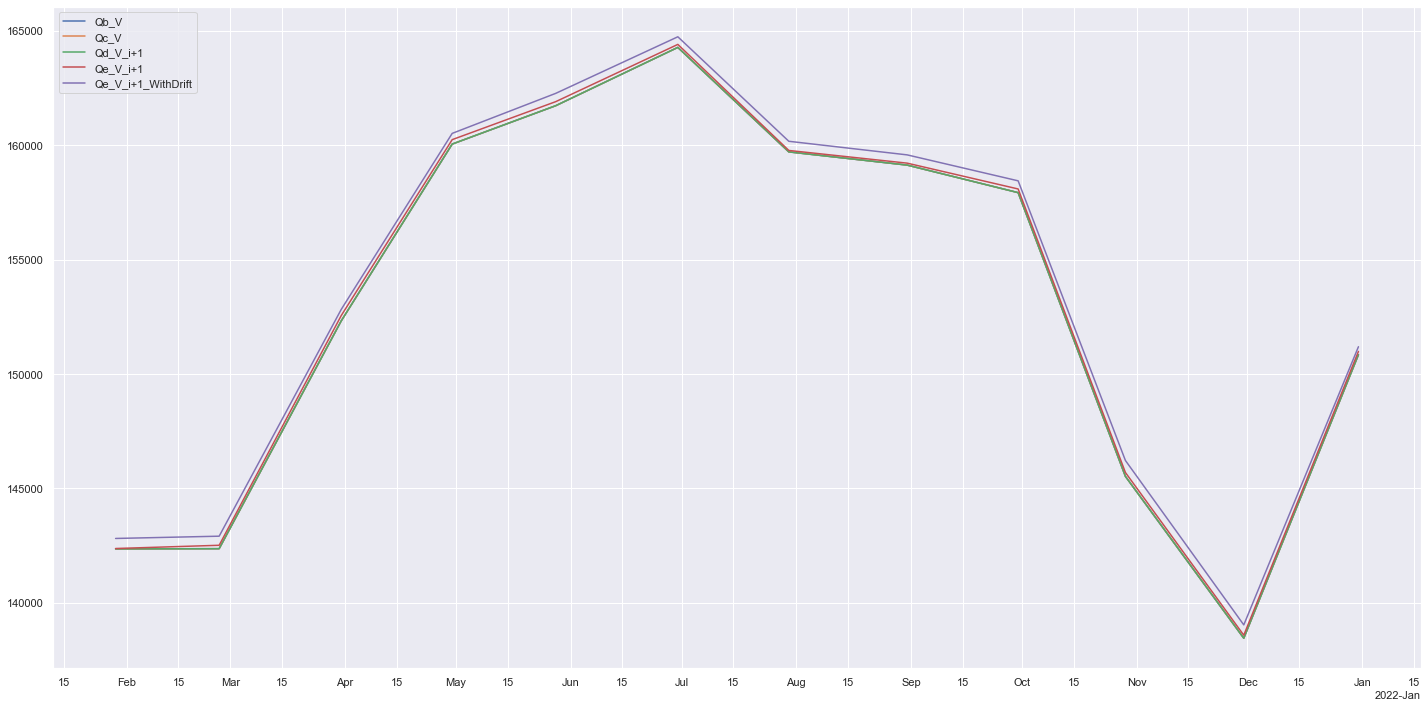

In [90]:
# Plotting the values:

Plotting(df_final, ["Qb_V", "Qc_V", "Qd_V_i+1","Qe_V_i+1", "Qe_V_i+1_WithDrift"])

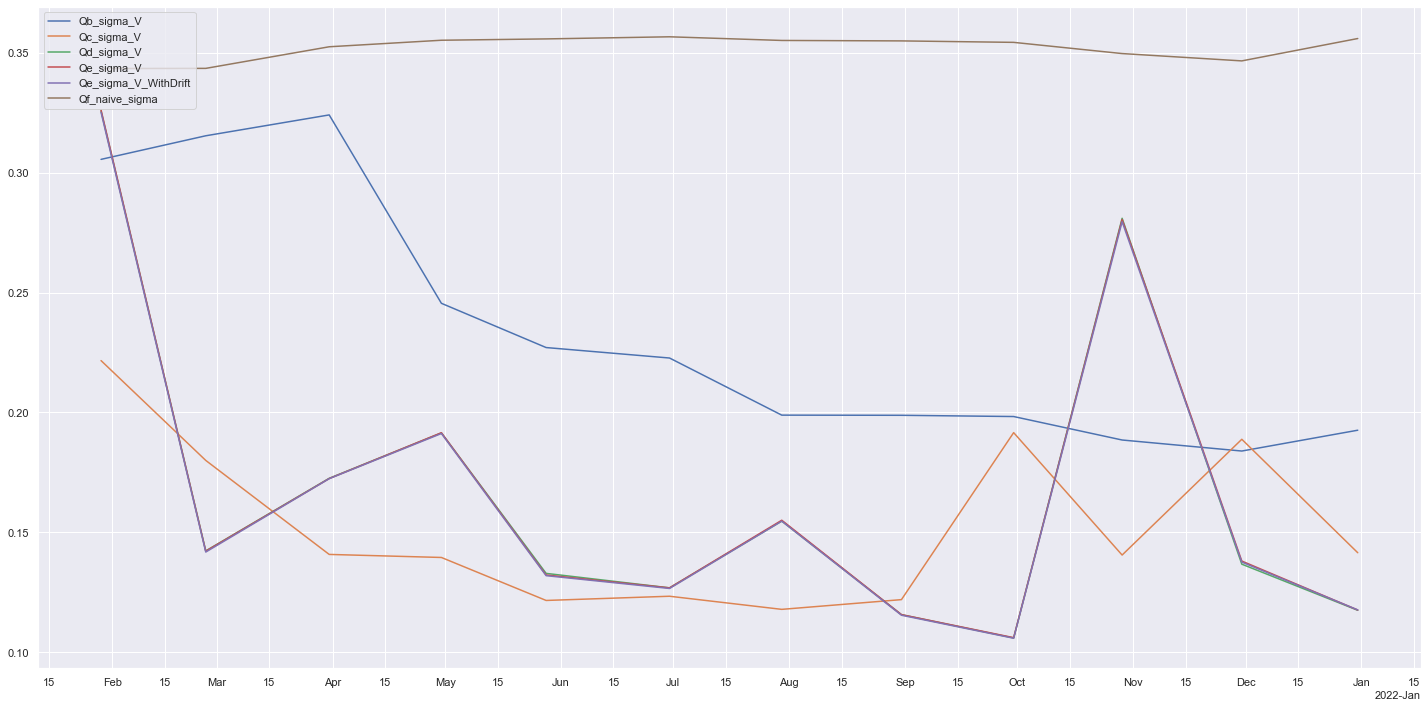

In [91]:
# Plotting the volatilities:

Plotting(df_final, ["Qb_sigma_V", "Qc_sigma_V", "Qd_sigma_V","Qe_sigma_V", "Qe_sigma_V_WithDrift", "Qf_naive_sigma"])

In [92]:
#dfi.export(df_final, "df_final.png")

# Question g:
    - Plot a figure of the default likelihood indicator with the five series of monthly default probabilities - see, for example, Vassalou and Xing (2004, Figure 1).

In [93]:
df_EDF = df[["Date", "Qb_EDF", "Qc_EDF", "Qd_EDF", "Qe_EDF", "Qe_EDF_WithDrift", "Qf_naive_EDF"]]
df_EDF

,Date,Qb_EDF,Qc_EDF,Qd_EDF,Qe_EDF,Qe_EDF_WithDrift,Qf_naive_EDF
0,2021-01-29,7.561693e-06,6.620397e-10,2.685400e-05,2.757585e-05,2.934204e-05,0.000088
1,2021-02-26,1.370026e-05,2.465923e-14,5.153679e-22,5.961414e-22,8.003887e-22,0.000088
2,2021-03-31,2.878373e-06,3.353067e-27,1.217766e-18,1.541114e-18,2.059257e-18,0.000025
3,2021-04-30,1.759604e-10,2.438062e-29,2.610593e-16,3.271140e-16,3.827631e-16,0.000017
4,2021-05-28,3.781194e-12,1.466799e-38,1.470861e-32,1.051973e-32,1.654298e-32,0.000013
5,2021-06-30,8.618951e-13,3.179163e-38,3.103769e-36,4.206026e-36,6.651390e-36,0.000009
6,2021-07-30,3.829485e-15,3.391392e-40,4.936610e-24,6.913899e-24,9.889164e-24,0.000017
7,2021-08-31,4.219784e-15,1.529210e-37,1.553341e-41,2.053606e-41,3.667162e-41,0.000016
8,2021-09-30,5.200334e-15,5.644309e-16,1.305597e-48,2.949093e-48,5.686421e-48,0.000014
9,2021-10-29,6.131503e-15,1.222899e-25,1.714407e-07,1.755686e-07,1.997174e-07,0.000024


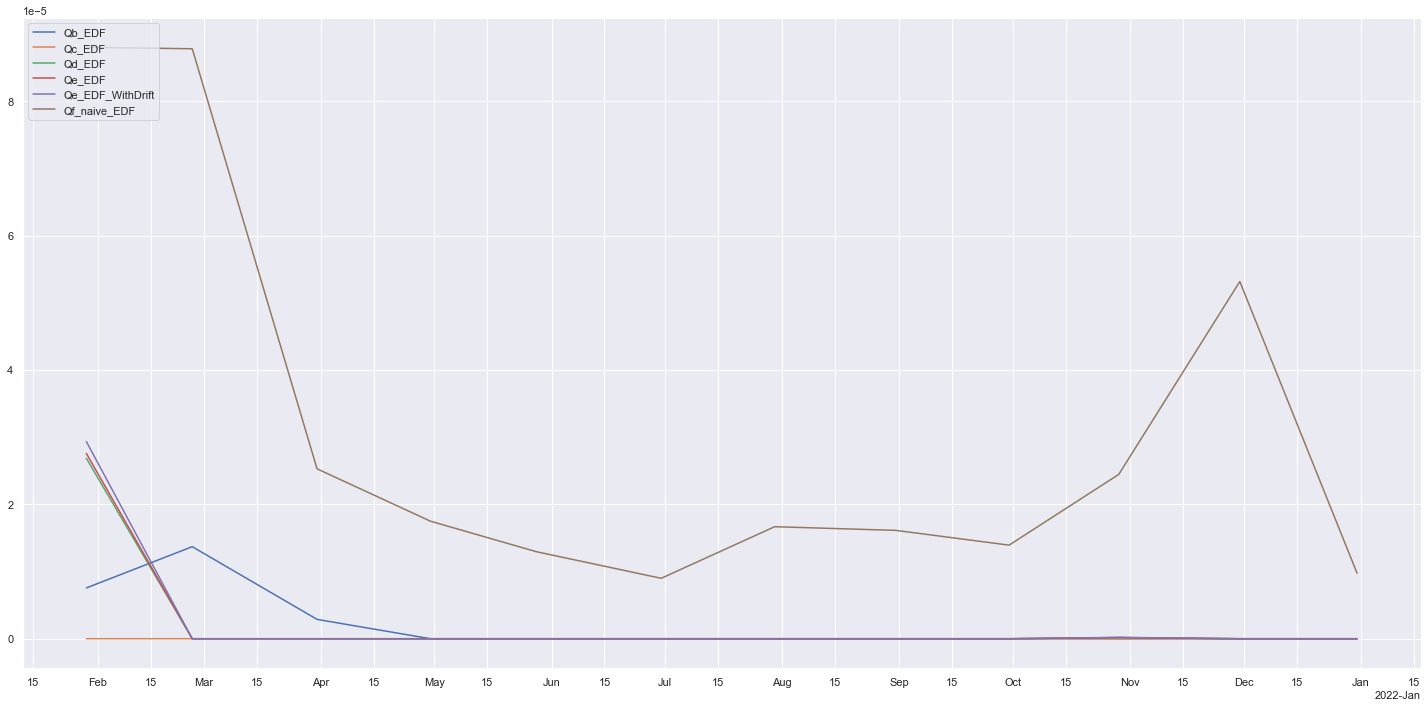

In [94]:
# Plotting the default likelihood indicator with the five series of monthly default probabilities.

Plotting(df_EDF, ["Qb_EDF", "Qc_EDF", "Qd_EDF", "Qe_EDF", "Qe_EDF_WithDrift", "Qf_naive_EDF"])

# Question h:
    - What are your main conclusions?

In [95]:
t2 = time.perf_counter()
print('time taken to run:',(t2-t1))

time taken to run: 26.954342800000003
